In [1]:
#%% imports
from model import NSFrozenLake
from amalearn.agent import AgentBase
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
#%% allowed actions
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

ACTIONS = [LEFT,DOWN,RIGHT,UP]

In [3]:
#%% hyperparameters
REPS = 20
EPISODES = 4000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 21365527

In [4]:
#%% get familiar with the environment
environment = NSFrozenLake(studentNum=STUDENT_NUM)

print("you can see the environment in each step by render command :")
environment.render()
print("\n\nand this is the bare map for debugging :")
print(environment.map)

you can see the environment in each step by render command :

------------------------------
| 0.000 | 0.001 | 0.001 | 0.037 | 
------------------------------
| 0.761 | 0.948 | 0.001 | 0.382 | 
------------------------------
| 0.145 | 0.738 | 0.001 | 0.786 | 
------------------------------
| 0.407 | 0.550 | 0.001 | 0.000 | 
------------------------------


and this is the bare map for debugging :
[[0.         0.001      0.001      0.03683382]
 [0.76073283 0.94763087 0.001      0.38179778]
 [0.14478832 0.73845298 0.001      0.78556568]
 [0.40680662 0.55034817 0.001      0.        ]]


# Q1

In [171]:
class ValueIteration():
    def __init__(self, env, discount, theta):
        self.env = env
        self.discount = discount
        self.theta = theta
        self.delta = 0
        self.state_values = np.zeros((4,4))
        self.q_values = np.zeros((4,4,4))
    
    def value_estimation(self):
        
        while(True):
            self.delta = 0
            for s0 in range(4):
                for s1 in range(4):
                    if(s0 == 3 and s1 == 3):
                        break
                    for action in ACTIONS:
                        states, probs, fail_probs, dones = \
                        self.env.possible_consequences(action=action ,state_now=(s0,s1))
                        states = np.array(states)
                        r = self.get_reward(fail_probs, dones)
                        
                        # update q value
                        self.q_values[s0,s1,action] = \
                        np.sum(probs * (r + self.discount * self.state_values[states[:,0], states[:,1]]))
                        
                    # save pervious state-value    
                    v = self.state_values[s0, s1]
                    
                    # update state-value
                    self.state_values[s0, s1] = np.max(self.q_values[s0,s1,:])
                    
                    self.delta = np.max([self.delta, abs(v - self.state_values[s0, s1])])
    
            if self.delta < self.theta:
                break
    
                
    
    def optimal_policy(self, state):
        action = np.argmax(self.q_values[state[0],state[1],:])
        return action
    
    def get_reward(self, fail_probs, dones):
        r = np.zeros_like(dones)
        r = np.where(dones, 49, ((1-fail_probs) * -1) + (fail_probs * -11))
        return r
    
    def get_state_values(self):
        return self.state_values
    
    def get_qs(self):
        return self.q_values
    
    def get_q(self, s, action):
        return self.q_values[s[0], s[1], action]

In [112]:
environment = NSFrozenLake(studentNum=STUDENT_NUM)
value_iter = ValueIteration(environment, 0.9, 1e-8)
value_iter.value_estimation()

In [113]:
state_values = value_iter.get_state_values()
print(state_values)

[[21.37158353 25.4731852  30.0295565  25.79018289]
 [17.90527998 29.59910387 35.09840739 33.47267704]
 [22.57226946 35.02047572 41.25583719 47.7128396 ]
 [29.58891272 40.93676459 48.04219591  0.        ]]


In [114]:
q_values = value_iter.get_qs()
print(q_values)

[[[18.05828617  8.40398482 21.37158353 18.05828617]
  [18.4692271  16.60484072 25.4731852  21.78252445]
  [22.23312653 30.0295565  22.16739028 25.92378728]
  [25.79018289 25.15193053 22.03378589 22.03378589]]

 [[ 8.25097863 17.57474074 16.04089361 17.90527998]
  [ 8.83507519 22.89890243 29.59910387 21.8026739 ]
  [17.13677555 35.09840739 25.36686767 26.00512003]
  [30.31607807 33.47267704 25.57205649 22.45391185]]

 [[17.83220433 21.15752063 22.57226946  8.50844222]
  [18.59269102 29.81789341 35.02047572 17.05884388]
  [24.07116704 41.25583719 33.92796745 30.77136849]
  [36.12106772 47.7128396  34.29014855 26.389528  ]]

 [[21.68902662 21.68902662 29.58891272 18.36371032]
  [22.33734563 30.23723172 40.93676459 23.75209445]
  [31.24784172 41.94737459 48.04219591 36.45042403]
  [ 0.          0.          0.          0.        ]]]


## optimal policy

In [115]:
def optimal_action_per_state():
    fl_map = np.zeros((4,4))

    for s0 in range(4):
        for s1 in range(4):
            optimal_action = value_iter.optimal_policy((s0, s1))
            fl_map[s0,s1] = optimal_action
    return fl_map          

In [116]:
def print_map(fl_map, action_show):
    fl_map0 = np.where(fl_map == 0, action_show[0], fl_map)
    fl_map1 = np.where(fl_map == 1, action_show[1], fl_map0)
    fl_map2 = np.where(fl_map == 2, action_show[2], fl_map1)
    fl_map3 = np.where(fl_map == 3, action_show[3], fl_map2)
    fl_map3[3,3] = u'🍕'
    print(fl_map3)

In [117]:
action_show = {0:"◀️",
               1:"🔽",
               2:"▶️",
               3:"🔼"}

fl_map = optimal_action_per_state()
print_map(fl_map, action_show)

[['▶️' '▶️' '🔽' '◀️']
 ['🔼' '▶️' '🔽' '🔽']
 ['▶️' '▶️' '🔽' '🔽']
 ['▶️' '▶️' '▶️' '🍕']]


In [118]:
def agent_op_run(REPS):
    env = NSFrozenLake(studentNum=STUDENT_NUM)
    mean_reward = 0
    
    for i in range(1, REPS+1):
        env.reset()
        current_state = (0,0)
        sum_reward = 0
        while(True):
            action = value_iter.optimal_policy(current_state)
            next_state, r, done,_ = env.step(action)
            sum_reward += r
            current_state = copy.deepcopy(next_state)
            
            if done:
                break
                
        mean_reward = ((i-1)/i) * mean_reward + (1/i) * sum_reward
            

    return mean_reward

In [169]:
optimal_mean_reward = agent_op_run(200)
print(optimal_mean_reward)

38.04999999999996


# Some Necessary Functions

In [5]:
def sliding_mean_reward(mean_reward, sliding_window_size):
    episodes = len(mean_reward) - sliding_window_size + 1
    sliding_mean_reward = np.zeros(episodes)
    
    for i in range(episodes):
        sliding_mean_reward[i] = np.mean(mean_reward[i: i+sliding_window_size])
        
    return sliding_mean_reward

In [6]:
def plot_sliding_mean_reward(sliding_mean_reward, label, ):
    plt.figure(figsize=(16, 10))
    episode_no = np.arange(len(sliding_mean_reward))
    plt.grid(True, linewidth=0.5, axis='y',color='#AAAAAA', linestyle='-')
    plt.plot(episode_no, sliding_mean_reward, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward (With Sliding Window)")
    plt.yticks(np.arange(np.ceil(sliding_mean_reward.min()) - 1, np.ceil(sliding_mean_reward.max()) + 5, 5))
    plt.legend(fontsize='large')
    plt.show();

In [7]:
def plot_epsilon(epsilons):
    episode_no = np.arange(len(epsilons))
    plt.plot(episode_no, epsilons)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.show();

In [221]:
def regret(optimal_mean_reward, sliding_mean_reward):
    regret = np.zeros(len(sliding_mean_reward))
    
    for i, mr in enumerate(sliding_mean_reward):
        if i == 0:
            regret[i] = optimal_mean_reward - mr
        else:
            regret[i] = regret[i-1] + (optimal_mean_reward - mr)
            
    return regret

In [222]:
def plot_regret(regrets, labels):
    plt.figure(figsize=(16, 10))
    plt.grid(True, linewidth=0.5, axis='y',color='#AAAAAA', linestyle='-')
    episode_no = np.arange(len(regrets[0]))
    
    for i, regret in enumerate(regrets):
        plt.plot(episode_no, regret, label=labels[i])
        
        
    plt.xlabel("Episode")
    plt.ylabel("Regret (With Sliding Window)")
    plt.legend(loc='lower right', fontsize='large')
    plt.show();

In [223]:
def plot_ar(sliding_mean_rewards, optimal_mean_reward, labels):
    plt.figure(figsize=(16, 10))
    plt.grid(True, linewidth=0.5, axis='y',color='#AAAAAA', linestyle='-')
    episode_no = np.arange(len(sliding_mean_rewards[0]))
    
    for i, sliding_mean_reward in enumerate(sliding_mean_rewards):
        plt.plot(episode_no, sliding_mean_reward, label=labels[i])
        
    plt.hlines(y = optimal_mean_reward, xmin = 0, xmax = len(sliding_mean_rewards[0]), color = 'r', linestyle = '--', label='Optimal policy')

        
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward (With Sliding Window)")
    y_min = np.min(sliding_mean_rewards)
    y_max = np.max(sliding_mean_rewards)
    plt.yticks(np.arange(np.ceil(y_min) - 1, np.ceil(optimal_mean_reward) + 10, 5))
    plt.legend(loc='lower right', fontsize='large')
    plt.show();

# Q2

In [172]:
class OffPolicyMCAgent(AgentBase):
    def __init__(self, id, environment, epsilon, discount, actions):
        super(OffPolicyMCAgent, self).__init__(id, environment)
        self.environment = environment
        self.epsilon = epsilon
        self.discount = discount
        self.available_actions = actions
        self.q_values = np.zeros((4,4,4))
        self.c = np.zeros((4,4,4))
        self.evaluation_policy = np.zeros((4,4))
        self.step_track = []
        self.g = 0
        self.w = 1

    
    def choose_action(self, state):
        my_random = np.random.uniform()

        if(my_random < self.epsilon):
            action = np.random.choice(self.available_actions)
            b = 0.25
        else:
            action = self.take_best_action(state)
            b = 1
        return action , b

    def take_action(self, state, action, b) -> (object, float, bool, object):
        next_state, r, done,_ = self.environment.step(action)
        self.step_track.append([state, action, r, b])

        return next_state, r, done,_
    

    def take_best_action(self, state):
        action = np.argmax(self.q_values[state[0], state[1], :])
        return action
    
    def get_step_track(self):
        return self.step_track
    
    def update_q(self, s, action, r):
        
        # update return
        self.g = self.discount * self.g + r
        
        # update c
        self.c[s[0], s[1], action] += self.w
        
        # update q
        self.q_values[s[0], s[1], action] += \
        (self.w / self.c[s[0], s[1], action]) * (self.g - self.q_values[s[0], s[1], action])
        
    def improve_policy(self, s):
        self.evaluation_policy[s[0], s[1]] = np.argmax(self.q_values[s[0],s[1],:])
        return self.evaluation_policy[s[0], s[1]]
        
    def update_w(self, b):
        self.w = self.w * (1 / b)
        
    def decay_eps(self, t):
        if t == 0:
            self.initial_epsilon = self.epsilon
        self.epsilon = self.initial_epsilon * np.exp(-t/500)
        return self.epsilon
    
    def get_qs(self):
        return self.q_values
        
        
    def reset_episode(self):
        self.step_track = []
        self.g = 0
        self.w = 1
            
    def reset(self):
        self.q_values = np.zeros((4,4,4))
        self.c = np.zeros((4,4,4))
        self.evaluation_policy = np.zeros((4,4))


## epsilon =  0.1

In [175]:
def agent_mc_eps_greedy_run():
    env = NSFrozenLake(studentNum=STUDENT_NUM)
    mean_reward = np.zeros(EPISODES)

    for rep in range(1, REPS+1): 
        off_mc_agent = OffPolicyMCAgent('1', env, 0.1, 0.9, ACTIONS)
        off_mc_agent.reset()
        sum_reward = np.zeros(EPISODES)
        for episode in range(EPISODES):
            env.reset()
            off_mc_agent.reset_episode()


            s = (0,0)
            # generate episode
            while(True):
                action, b = off_mc_agent.choose_action(s)
                s_prime, r, done,_ = off_mc_agent.take_action(s, action, b)
                sum_reward[episode] += r
                
                s = copy.deepcopy(s_prime)

                if done:
                    break

            # update
            steps = off_mc_agent.get_step_track()
            for step in reversed(steps):
                s, action, r, b = step[0], step[1], step[2], step[3]
                off_mc_agent.update_q(s, action, r)
                greedy_action = off_mc_agent.improve_policy(s)
                if(greedy_action != action):
                    break
                else:
                    off_mc_agent.update_w(b)

            # calculate mean reward
            mean_reward[episode] = ((rep - 1)/rep) * mean_reward[episode] + (1/rep) * sum_reward[episode]
    
    return mean_reward, off_mc_agent.get_qs()

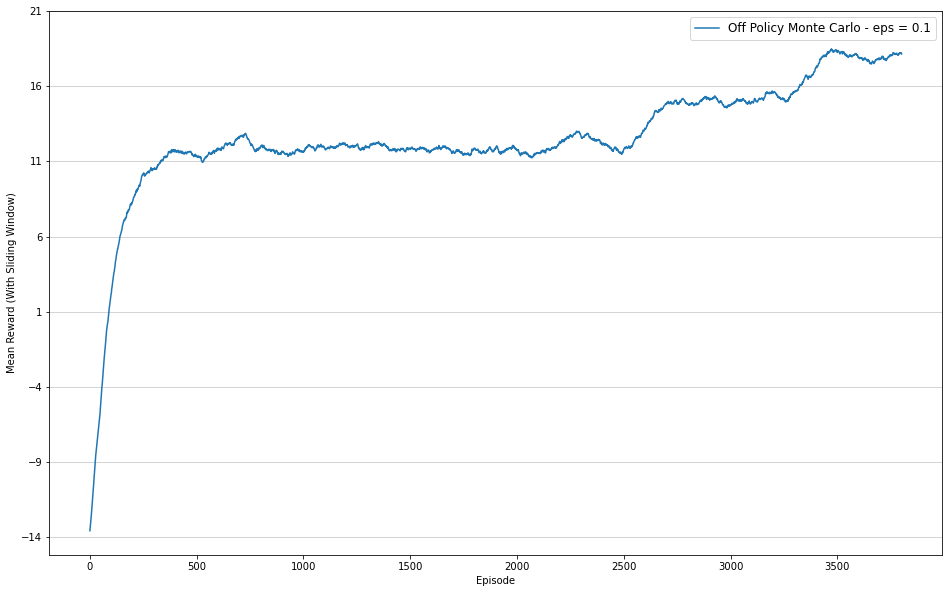

In [214]:
EPISODES = 4000
mc_mr, q = agent_mc_eps_greedy_run()
mc_smr = sliding_mean_reward(mc_mr, 200)
plot_sliding_mean_reward(mc_smr, "Off Policy Monte Carlo - eps = 0.1")

In [215]:
print(q)

[[[ -9.67989193  -7.10910339  15.92551814  11.00444745]
  [ -7.48612912  -9.03081303  22.31092828  18.39189238]
  [ 21.43699286  27.28286235  19.83475355  23.81928216]
  [ 22.36532704   4.97274     19.86369573  13.38246647]]

 [[-11.         -10.09428729 -10.795245   -10.9       ]
  [-11.           3.67033333  25.6645443   20.84520962]
  [ -6.37141202  31.94217368   9.15299915  18.35800104]
  [ 24.47736674  19.18333      8.85495     10.7194757 ]]

 [[-10.00721619 -10.9525     -11.         -11.        ]
  [-11.         -11.          31.47049726 -11.        ]
  [  4.75114379  39.04286586  -0.18725189  26.37580899]
  [ 33.24475714  49.           0.         -11.        ]]

 [[-11.         -11.         -11.          -4.4070942 ]
  [-10.7657205    5.26333333  36.36098445 -11.        ]
  [ 11.01365386  40.56635484  47.32930606  32.51301204]
  [  0.           0.           0.           0.        ]]]


## Decayed epsilon

In [217]:
def agent_mc_dycayed_run():
    env = NSFrozenLake(studentNum=STUDENT_NUM)
    mean_reward = np.zeros(EPISODES)
    epsilons = np.zeros(EPISODES)


    for rep in range(1, REPS+1): 
        off_mc_agent = OffPolicyMCAgent('2', env, 0.8, 0.9, ACTIONS)
        off_mc_agent.reset()
        sum_reward = np.zeros(EPISODES)
        for episode in range(EPISODES):
            env.reset()
            off_mc_agent.reset_episode()
            
            eps = off_mc_agent.decay_eps(episode)
            if rep == 1:
                epsilons[episode] = eps


            s = (0,0)
            # generate episode
            while(True):
                action, b = off_mc_agent.choose_action(s)
                s_prime, r, done,_ = off_mc_agent.take_action(s, action, b)
                sum_reward[episode] += r
                
                s = copy.deepcopy(s_prime)

                if done:
                    break

            # update
            steps = off_mc_agent.get_step_track()
            for step in reversed(steps):
                s, action, r, b = step[0], step[1], step[2], step[3]
                off_mc_agent.update_q(s, action, r)
                greedy_action = off_mc_agent.improve_policy(s)
                if(greedy_action != action):
                    break
                else:
                    off_mc_agent.update_w(b)

            # calculate mean reward
            mean_reward[episode] = ((rep - 1)/rep) * mean_reward[episode] + (1/rep) * sum_reward[episode]
    
    return mean_reward, epsilons, off_mc_agent.get_qs()

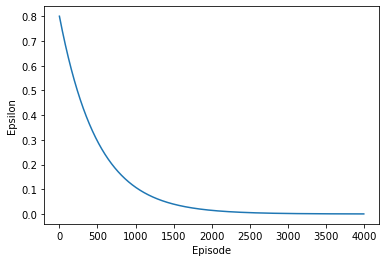

In [218]:
mc_decayed_mr, epsilons, q = agent_mc_dycayed_run()
plot_epsilon(epsilons)

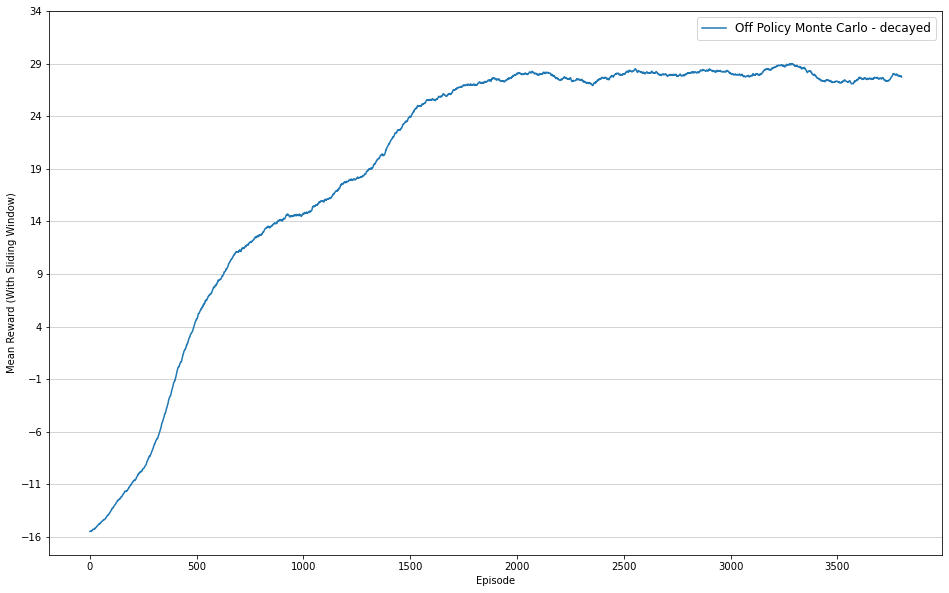

In [219]:
mc_decayed_smr = sliding_mean_reward(mc_decayed_mr, 200)
plot_sliding_mean_reward(mc_decayed_smr, "Off Policy Monte Carlo - decayed")

In [220]:
print(q)

[[[  9.05460705   4.78758443  19.59074817  19.49008018]
  [ 21.34121201 -10.6148212   23.96120216  15.82864789]
  [ 21.74249913  28.53953275  23.39557179  23.19326447]
  [ 23.70404817 -11.         -10.59049     22.42724039]]

 [[-11.         -10.95       -11.          11.60067766]
  [-11.           3.67033333  21.52124437   0.        ]
  [-10.28910893  33.20976817   4.46043333  24.32080771]
  [ 28.55781708 -10.89142857  15.47326667   6.919455  ]]

 [[  0.         -11.         -11.          11.12898212]
  [-11.          18.274       32.65947368 -11.        ]
  [  7.17584211  39.80734405   0.27083333  20.97346265]
  [  0.          47.64732667 -11.           0.        ]]

 [[-11.         -11.         -11.           0.        ]
  [-11.          37.79        39.608125    11.0055    ]
  [  4.74341463  40.27629434  47.81006272  36.36758276]
  [  0.           0.           0.           0.        ]]]


## Regret comparision

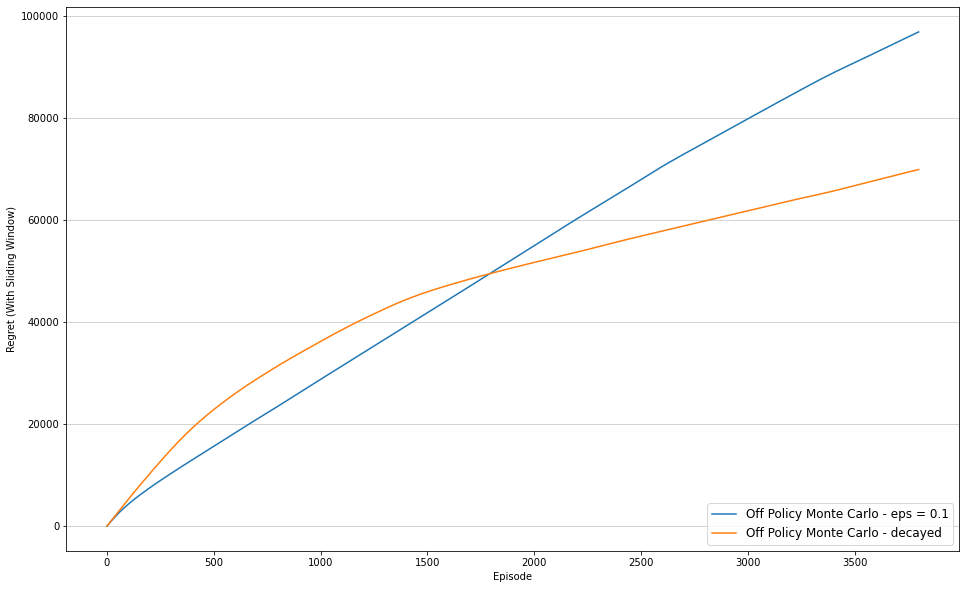

In [224]:
mc_regret = regret(optimal_mean_reward, mc_smr)
mc_decayed_regret = regret(optimal_mean_reward, mc_decayed_smr)
regrets = [mc_regret, mc_decayed_regret]
labels = ["Off Policy Monte Carlo - eps = 0.1", "Off Policy Monte Carlo - decayed"]
plot_regret(regrets, labels)

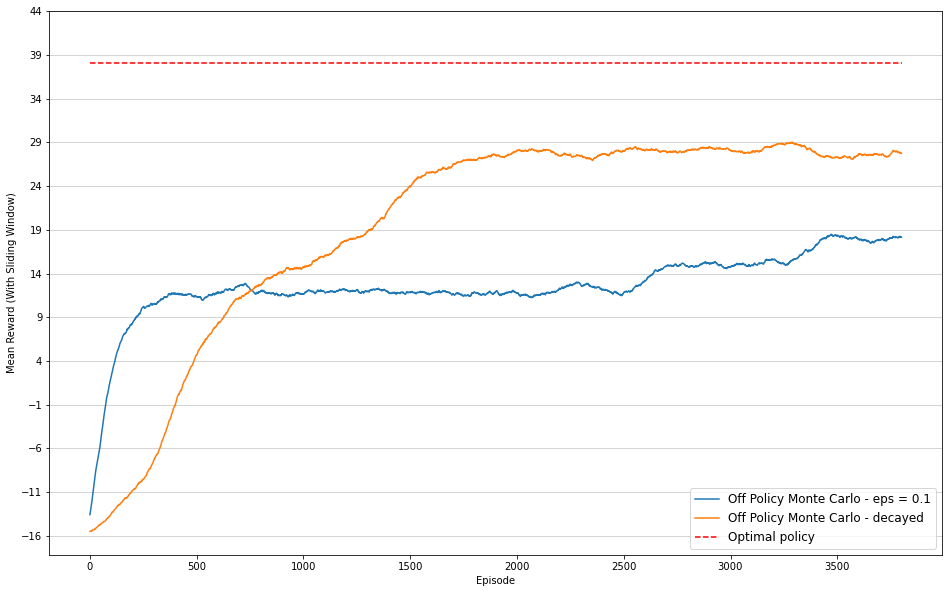

In [225]:
sliding_mean_rewards = [mc_smr, mc_decayed_smr]
plot_ar(sliding_mean_rewards, optimal_mean_reward, labels)

## Q-Learning

In [226]:
class QLearningAgent(AgentBase):
    def __init__(self, id, environment, epsilon, discount, learning_rate, actions):
        super(QLearningAgent, self).__init__(id, environment)
        self.environment = environment
        self.epsilon = epsilon
        self.discount = discount
        self.lr = learning_rate
        self.available_actions = actions
        self.q_values = np.zeros((4,4,4))


    def choose_action(self, state) -> (object, float, bool, object):
        
        my_random = np.random.uniform()

        if(my_random < self.epsilon):
            action = np.random.choice(self.available_actions)
        else:
            action = self.choose_best_action(state)
            
        return action
    
    def choose_best_action(self, state):
        action = np.argmax(self.q_values[state[0], state[1], :])
        return action 
    

    def take_action(self, action):
        next_state, r, done,_ = self.environment.step(action)
        return next_state, r, done, _
    

    
    def update_q(self, s, s_prime, action, r):
        
        # update q
        self.q_values[s[0], s[1], action] +=  self.lr * \
                                        ((r + (self.discount * np.max(self.q_values[s_prime[0], s_prime[1], :]))) - \
                                         self.q_values[s[0], s[1], action])
        
    def decay_eps(self, t):
        if t == 0:
            self.initial_epsilon = self.epsilon
        self.epsilon = self.initial_epsilon * np.exp(-t/400)
        return self.epsilon
    
        
    def decay_lr(self, t):
        if t == 0:
            self.initial_lr = self.lr
        self.lr = self.initial_lr * np.exp(-t/500)
        return self.lr
    
    def get_qs(self):
        return self.q_values
    
    def get_q(self, s, action):
        return self.q_values[s[0], s[1], action]
        
    def reset(self):
        self.q_values = np.zeros((4,4,4))

In [227]:
def agent_qlearning_run(decay_lr_flag, learning_rate):
    env = NSFrozenLake(studentNum=STUDENT_NUM)
    mean_reward = np.zeros(EPISODES)
    lrs = np.zeros(EPISODES)
    epsilons = np.zeros(EPISODES)


    for rep in range(1, REPS+1): 
        qlr_agent = QLearningAgent('3', env, 0.8, 0.9, learning_rate, ACTIONS)
        qlr_agent.reset()
        sum_reward = np.zeros(EPISODES)
        for episode in range(EPISODES):
            env.reset()
            
            eps = qlr_agent.decay_eps(episode)
            if rep == 1:
                epsilons[episode] = eps
            
            if decay_lr_flag:
                lr = qlr_agent.decay_lr(episode)
                if rep == 1:
                    lrs[episode] = lr


            s = (0,0)
            # generate episode and update q
            while(True):
                # choose A from S using eps-greedy policy
                a = qlr_agent.choose_action(s)
                
                # take action A, observe R, S_prime
                s_prime, r, done, _ = qlr_agent.take_action(a)
                
                # update q value
                qlr_agent.update_q(s, s_prime, a, r)
                
                sum_reward[episode] += r
                
                s = copy.deepcopy(s_prime)
                
                if done:
                    break
                    


            # calculate mean reward
            mean_reward[episode] = ((rep - 1)/rep) * mean_reward[episode] + (1/rep) * sum_reward[episode]
    
    if decay_lr_flag:
        return mean_reward, lrs, epsilons, qlr_agent.get_qs()
    else:
        return mean_reward, epsilons, qlr_agent.get_qs()

## learning_rate = 0.1

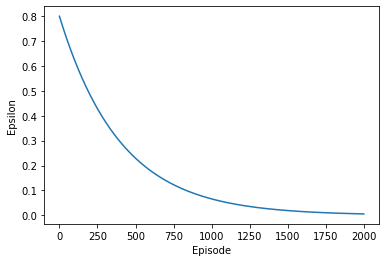

In [228]:
EPISODES = 2000
qlr_mr, epsilons, q = agent_qlearning_run(False, 0.1)
plot_epsilon(epsilons)

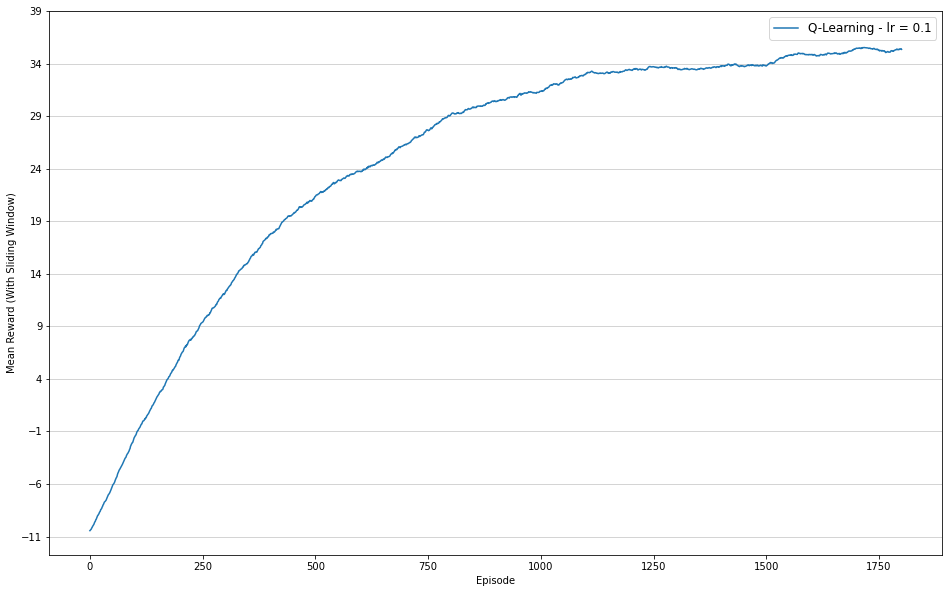

In [229]:
qlr_smr = sliding_mean_reward(qlr_mr, 200)
plot_sliding_mean_reward(qlr_smr, "Q-Learning - lr = 0.1")

In [230]:
print(q)

[[[ 1.44504373e+01  2.34964743e+00  2.13487207e+01  1.54002211e+01]
  [ 1.71353819e+01 -2.57021164e+00  2.55569146e+01  1.78424816e+01]
  [ 2.08518605e+01  3.05749165e+01  1.99790360e+01  2.49949949e+01]
  [ 2.46191031e+01 -1.79180039e+00  4.15508217e+00  4.60634877e+00]]

 [[-3.02159000e+00 -4.42000000e-01 -3.78290000e+00  1.28193661e+01]
  [-1.17100000e-01  3.17272538e-02  0.00000000e+00  1.06997014e+01]
  [ 1.82621771e+00  3.62777762e+01  1.39514517e+01  2.19112324e+01]
  [ 2.82406887e+01 -5.73401000e-01 -7.58849495e-01  4.73027660e+00]]

 [[-2.88100000e-01 -3.21913418e-01 -2.31222823e+00 -1.21520000e+00]
  [-2.07100000e-01 -1.10000000e+00  3.03743485e+01  0.00000000e+00]
  [ 1.51229212e+01  4.26500130e+01  1.52098122e+01  2.95850966e+01]
  [ 0.00000000e+00  3.67261333e+01  0.00000000e+00  1.24085281e+00]]

 [[-1.10000000e+00 -1.00000000e-01  3.34149176e+00 -1.09000000e+00]
  [-1.10000000e+00 -1.00000000e-01  3.64583332e+01  3.52298680e+00]
  [ 1.56902537e+01  4.01947961e+01  4.8996

## decayed learning_rate

In [231]:
def plot_lr(lrs):
    episode_no = np.arange(len(lrs))
    plt.plot(episode_no, lrs)
    plt.xlabel("Episode")
    plt.ylabel("Learning rate")
    plt.show();

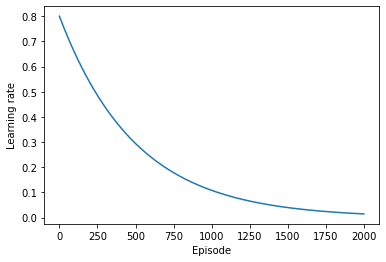

In [242]:
qlr_decayed_mr, lrs, epsilons, q = agent_qlearning_run(True, 0.8)
plot_lr(lrs)

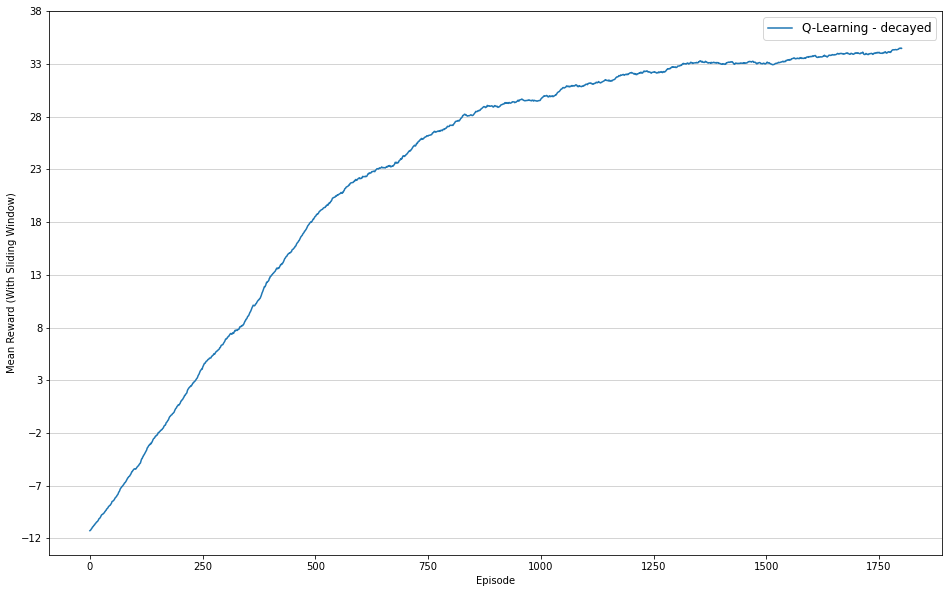

In [243]:
qlr_decayed_smr = sliding_mean_reward(qlr_decayed_mr, 200)
plot_sliding_mean_reward(qlr_decayed_smr, "Q-Learning - decayed")

In [244]:
print(q)

[[[ 1.71937753e+01  8.46072987e+00  2.01191440e+01  1.75887366e+01]
  [ 1.81519663e+01  1.07599196e+01  2.42307035e+01  2.10524966e+01]
  [ 2.25499626e+01  2.94582486e+01  2.10978714e+01  2.54546267e+01]
  [ 2.53873046e+01  1.93480370e+01  1.56347081e+01  2.08051845e+01]]

 [[ 2.67804092e+00 -7.10972999e-01  3.04835421e-01  1.52734088e+01]
  [ 1.86750883e+00 -8.38161457e-01  2.47726126e+01 -8.14441741e+00]
  [ 9.97826361e+00  3.48080014e+01  2.10492687e+01  2.55193890e+01]
  [ 3.03342640e+01  2.27578159e+01  1.66037891e+01  1.78246541e+01]]

 [[-1.19288407e+00 -7.50619139e+00  3.74624001e+00 -1.37710592e+00]
  [-1.29872257e-01  5.48699363e-01  3.02435763e+01  3.76600298e+00]
  [ 1.50903506e+01  4.11539445e+01  3.14532517e+01  2.91042681e+01]
  [ 6.54386201e+00  4.80391975e+01  2.91138648e+01  2.59174609e+01]]

 [[-7.88334039e+00 -4.47285378e-02  1.42796060e+00  0.00000000e+00]
  [ 0.00000000e+00  3.17276723e+00  3.67151608e+01  0.00000000e+00]
  [ 3.08758854e+01  4.17445745e+01  4.8432

## regret comparision

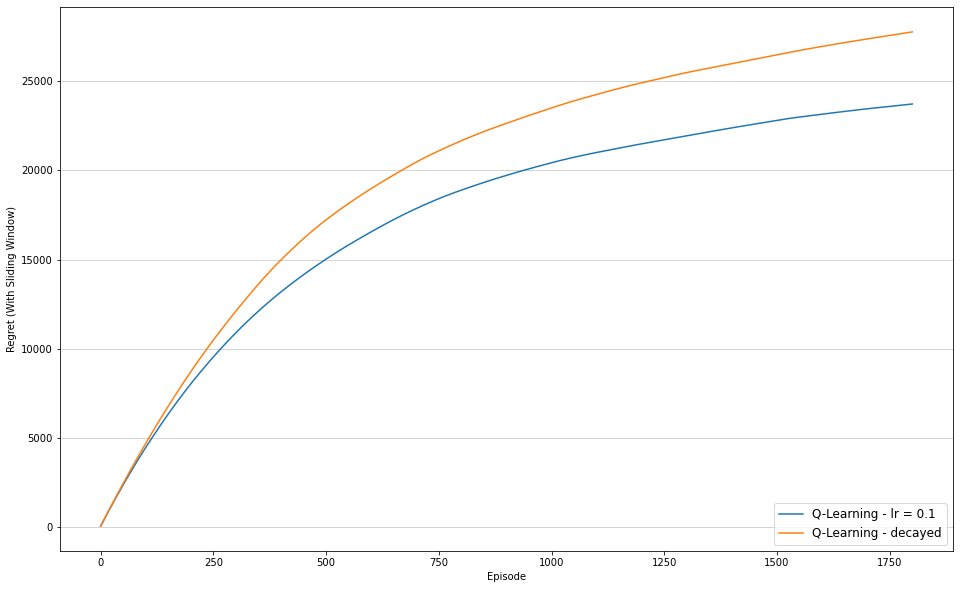

In [245]:
qlr_regret = regret(optimal_mean_reward, qlr_smr)
qlr_decayed_regret= regret(optimal_mean_reward, qlr_decayed_smr)
regrets = [qlr_regret, qlr_decayed_regret]
labels = ["Q-Learning - lr = 0.1", "Q-Learning - decayed"]
plot_regret(regrets, labels)

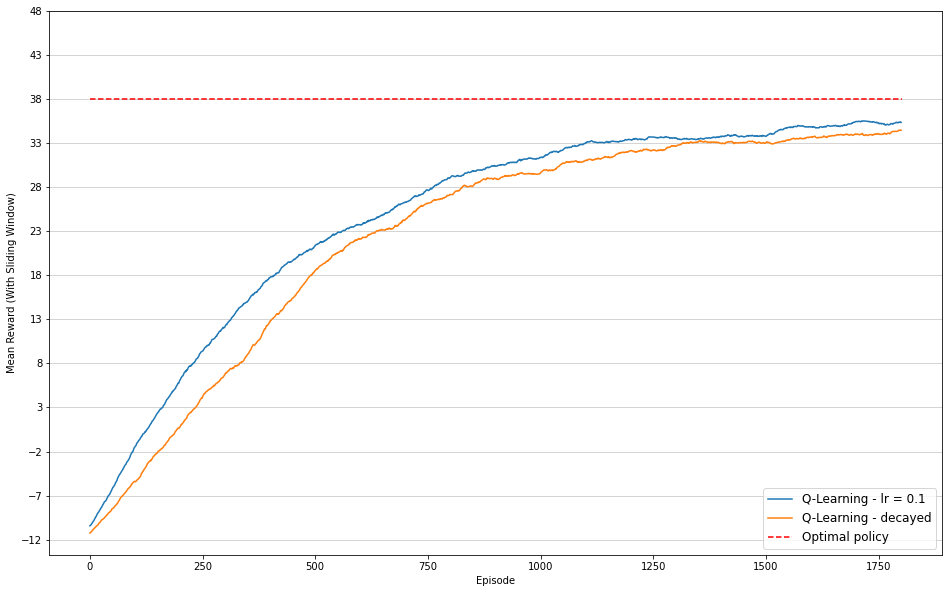

In [246]:
sliding_mean_rewards = [qlr_smr, qlr_decayed_smr]
plot_ar(sliding_mean_rewards, optimal_mean_reward, labels)

## SARSA

In [202]:
class SarsaAgent(AgentBase):
    def __init__(self, id, environment, epsilon, discount, learning_rate, actions):
        super(SarsaAgent, self).__init__(id, environment)
        self.environment = environment
        self.epsilon = epsilon
        self.discount = discount
        self.lr = learning_rate
        self.available_actions = actions
        self.q_values = np.zeros((4,4,4))


    def choose_action(self, state) -> (object, float, bool, object):
        
        my_random = np.random.uniform()

        if(my_random < self.epsilon):
            action = np.random.choice(self.available_actions)
        else:
            action = self.choose_best_action(state)
            
        return action
    
    def choose_best_action(self, state):
        action = np.argmax(self.q_values[state[0], state[1], :])
        return action 
    

    def take_action(self, action):
        next_state, r, done,_ = self.environment.step(action)
#         print(current_state, action, next_state, r, done)
        return next_state, r, done, _


    
    def update_q(self, s, s_prime, action, action_prime, r):
        
        # update q
        self.q_values[s[0], s[1], action] +=  self.lr * \
            ((r + (self.discount * self.q_values[s_prime[0], s_prime[1], action_prime])) - self.q_values[s[0], s[1], action])
        
    def decay_eps(self, t):
        if t == 0:
            self.initial_epsilon = self.epsilon
        self.epsilon = self.initial_epsilon * np.exp(-t/400)
        return self.epsilon
        
    def get_q(self):
        return self.q_values
        
    def reset(self):
        self.q_values = np.zeros((4,4,4))

In [203]:
def agent_sarsa_run():
    env = NSFrozenLake(studentNum=STUDENT_NUM)
    mean_reward = np.zeros(EPISODES)
    epsilons = np.zeros(EPISODES)


    for rep in range(1, REPS+1): 
        sar_agent = SarsaAgent('4', env, 0.8, 0.9, 0.1, ACTIONS)
        sar_agent.reset()
        sum_reward = np.zeros(EPISODES)
        for episode in range(EPISODES):
            env.reset()
            
            eps = sar_agent.decay_eps(episode)

            s = (0,0)
            # choose A from S using eps-greedy policy
            a = sar_agent.choose_action(s)
            
            # generate episode and update q
            while(True):

                # take action A, observe R, S_prime
                s_prime, r, done, _ = sar_agent.take_action(a)
                
                # choose A_prime from S_prime using eps-greedy policy
                a_prime = sar_agent.choose_action(s_prime)

                # update q value
                sar_agent.update_q(s, s_prime, a, a_prime, r)
                
                sum_reward[episode] += r

                a = copy.deepcopy(a_prime)
                s = copy.deepcopy(s_prime)
                
                if done:
                    break
                    


            # calculate mean reward
            mean_reward[episode] = ((rep - 1)/rep) * mean_reward[episode] + (1/rep) * sum_reward[episode]
    

    return mean_reward, sar_agent.get_q()

In [204]:
EPISODES = 2000
sar_mr, q = agent_sarsa_run()

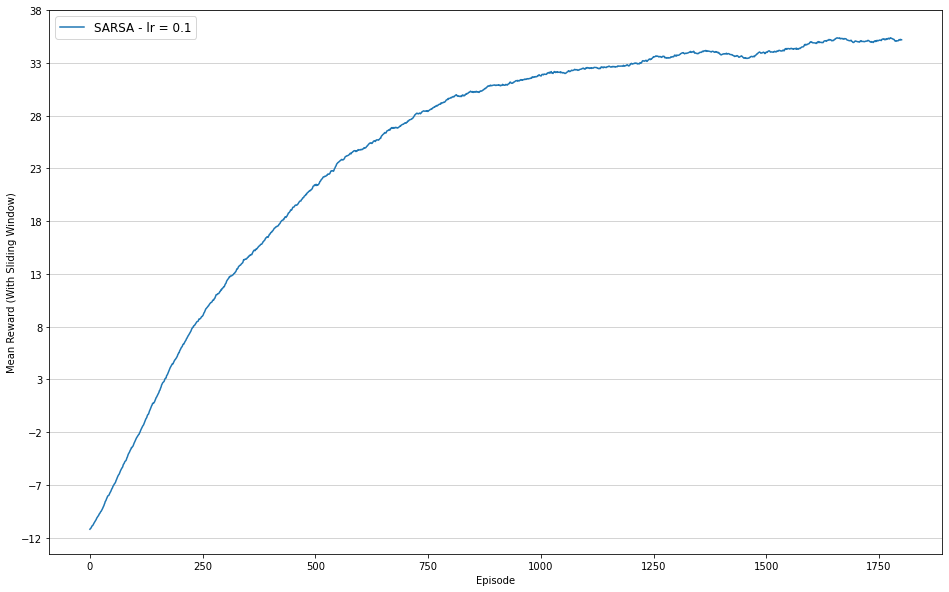

In [205]:
sar_smr = sliding_mean_reward(sar_mr, 200)
plot_sliding_mean_reward(sar_smr, "SARSA - lr = 0.1")

In [206]:
print(q)

[[[  7.96617458  -7.62955087  18.41355201  11.37248851]
  [  7.95086207 -10.47155383  22.30069675  14.13778254]
  [ 14.41718493  27.38610801   7.91655794  18.03062825]
  [ 22.94115719  -4.6262779   -5.4097583   -4.57275463]]

 [[ -5.80492614  -2.54468532  -3.08759086   7.73583153]
  [ -1.1979461   -1.49121159  -1.10484747   4.18329433]
  [-10.36654617  33.83964247   8.80320395  15.13312025]
  [ 24.1756061   -2.61604748  -1.68042689  -3.48482468]]

 [[ -3.79740206  -2.92130896  -3.57781167  -3.81729114]
  [ -0.90126414  -0.59962718  19.58910486  -3.09432363]
  [ -1.50305137  42.11578329  12.83794838  19.20454765]
  [  2.66319254  38.04415238   0.7379      -2.49914627]]

 [[ -2.27711     -1.1          2.35740639   0.        ]
  [ -0.1         -0.15633238  32.95650574   0.36119737]
  [ 15.90198536  40.11519124  48.55491388  30.14089816]
  [  0.           0.           0.           0.        ]]]


## 2-step tree backup

In [207]:
class TwoStepTreeBackupAgent(AgentBase):
    def __init__(self, id, environment, epsilon, discount, learning_rate, actions):
        super(TwoStepTreeBackupAgent, self).__init__(id, environment)
        self.environment = environment
        self.epsilon = epsilon
        self.discount = discount
        self.lr = learning_rate
        self.available_actions = actions
        self.q_values = np.zeros((4,4,4))


    def choose_action(self, state) -> (object, float, bool, object):
        
        my_random = np.random.uniform()

        if(my_random < self.epsilon):
            action = np.random.choice(self.available_actions)
        else:
            action = self.choose_best_action(state)
            
        return action
    
    def choose_best_action(self, state):
        action = np.argmax(self.q_values[state[0], state[1], :])
        return action 
    

    def take_action(self, action):
        next_state, r, done,_ = self.environment.step(action)
#         print(current_state, action, next_state, r, done)
        return next_state, r, done, _


    
    def update_q(self, s, s_prime, s_zegond, a, a_prime, r, r_prime):
        
        # update q
        x = 0
        for action in self.available_actions:
            if action != a_prime:
                x += (self.greedy_policy_prob(s_prime, action) * self.q_values[s_prime[0], s_prime[1], action])
                
        y = 0
        for action in self.available_actions:
                y += (self.greedy_policy_prob(s_zegond, action) * self.q_values[s_zegond[0], s_zegond[1], action])
                
          
        G = r + \
            self.discount * x + \
            self.discount * self.greedy_policy_prob(s_prime, a_prime) * (r_prime + self.discount * y)
        
        self.q_values[s[0], s[1], a] += self.lr * (G - self.q_values[s[0], s[1], a])
        
        
    def decay_eps(self, t):
        if t == 0:
            self.initial_epsilon = self.epsilon
        self.epsilon = self.initial_epsilon * np.exp(-t/400)
        return self.epsilon
        
    def update_pre_terminal_q(self, s, a, r):
        G = r
        self.q_values[s[0], s[1], a] += self.lr * (G - self.q_values[s[0], s[1], a])
        
        
    def greedy_policy_prob(self, state, action):
        p = 0
        greedy_action = np.argmax(self.q_values[state[0], state[1], :])
        if greedy_action == action:
            p = 1
        return p
        
    def get_q(self):
        return self.q_values
        
    def reset(self):
        self.q_values = np.zeros((4,4,4))

In [208]:
def agent_backup_run():
    env = NSFrozenLake(studentNum=STUDENT_NUM)
    mean_reward = np.zeros(EPISODES)
    epsilons = np.zeros(EPISODES)


    for rep in range(1, REPS+1): 
        backup_agent = TwoStepTreeBackupAgent('5', env, 0.8, 0.9, 0.1, ACTIONS)
        backup_agent.reset()
        sum_reward = np.zeros(EPISODES)
        for episode in range(EPISODES):
            env.reset()
            
            eps = backup_agent.decay_eps(episode)

            s = (0,0)
            # step 1
            a = backup_agent.choose_action(s)
            s_prime, r, done, _ = backup_agent.take_action(a)
            sum_reward[episode] += r
                
            if done:
                # update pre terminal state
                backup_agent.update_pre_terminal_q(s, a, r)
                continue
            
            # step 2
            a_prime = backup_agent.choose_action(s_prime)
            s_zegond, r_prime, done, _ = backup_agent.take_action(a_prime)
            sum_reward[episode] += r_prime

            # update q value
            backup_agent.update_q(s, s_prime, s_zegond, a, a_prime, r, r_prime)
            
            
            if done:
                # update pre terminal state
                backup_agent.update_pre_terminal_q(s_prime, a_prime, r_prime)
                continue

        
            
            
            s = copy.deepcopy(s_prime)
            a = copy.deepcopy(a_prime)
            r = copy.deepcopy(r_prime)
            s_prime = copy.deepcopy(s_zegond)
            
            # generate episode and update q
            while(True):
                
                a_prime = backup_agent.choose_action(s_prime)
                s_zegond, r_prime, done, _ = backup_agent.take_action(a_prime)
                sum_reward[episode] += r_prime

                # update q value
                backup_agent.update_q(s, s_prime, s_zegond, a, a_prime, r, r_prime)
                

                
                
                s = copy.deepcopy(s_prime)
                a = copy.deepcopy(a_prime)
                r = copy.deepcopy(r_prime)
                s_prime = copy.deepcopy(s_zegond)
                
                if done:
                    # update pre terminal state
                    backup_agent.update_pre_terminal_q(s, a, r)
                    break
                    


            # calculate mean reward
            mean_reward[episode] = ((rep - 1)/rep) * mean_reward[episode] + (1/rep) * sum_reward[episode]
    

    return mean_reward, backup_agent.get_q()    

In [209]:
backup_mr, q = agent_backup_run()

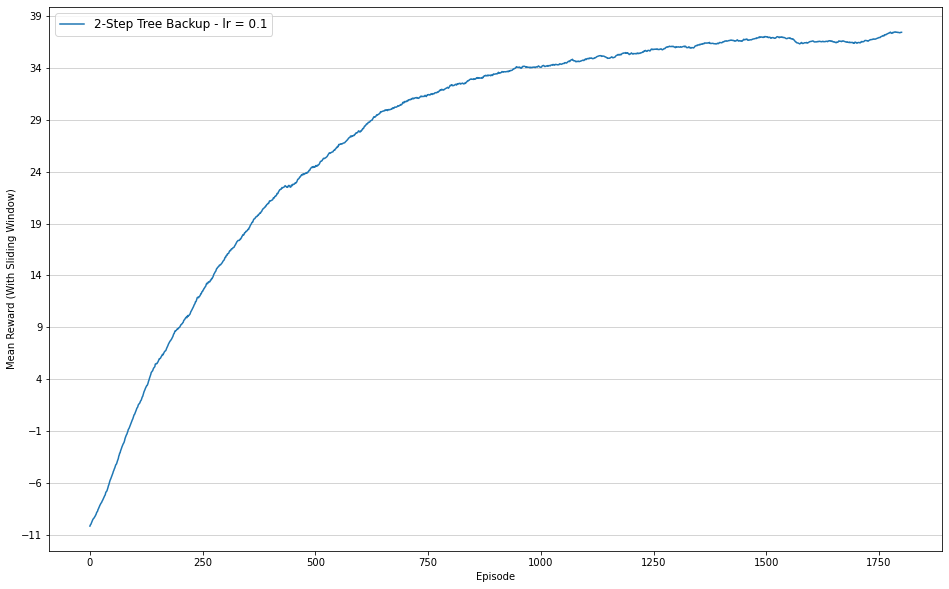

In [210]:
backup_smr = sliding_mean_reward(backup_mr, 200)
plot_sliding_mean_reward(backup_smr, "2-Step Tree Backup - lr = 0.1")

In [211]:
print(q)

[[[ 10.80140894  -2.29097732  18.88578414  10.46893897]
  [ 14.83151532  -9.65277241  21.31910872  13.61507105]
  [ 20.66306734  28.11664987  20.85805395  21.58212897]
  [ 20.80688029   6.87228677   2.10863456   7.31687092]]

 [[ -2.97422298  -2.99221265  -2.09        15.72761915]
  [ -0.19        -1.1         -0.21508328   7.65331239]
  [-10.22471341  32.73499626  13.33105966  20.85445166]
  [ 30.72387459  -2.20857175   9.46339497   0.63741372]]

 [[ -1.406071    -2.223361    -3.833849    -1.34922395]
  [ -0.289        7.22033752   2.86820179  -2.981     ]
  [  2.89599557  41.87430209  -5.25637245  25.6985994 ]
  [ 28.10777068  11.4511      -1.1          2.38955968]]

 [[ -0.2133361   -1.1          0.          -0.19      ]
  [ -2.09         5.93911158  39.69773959   6.11800375]
  [  8.61427924  40.10422777  48.85019021  34.67532263]
  [  0.           0.           0.           0.        ]]]


## regret comparision

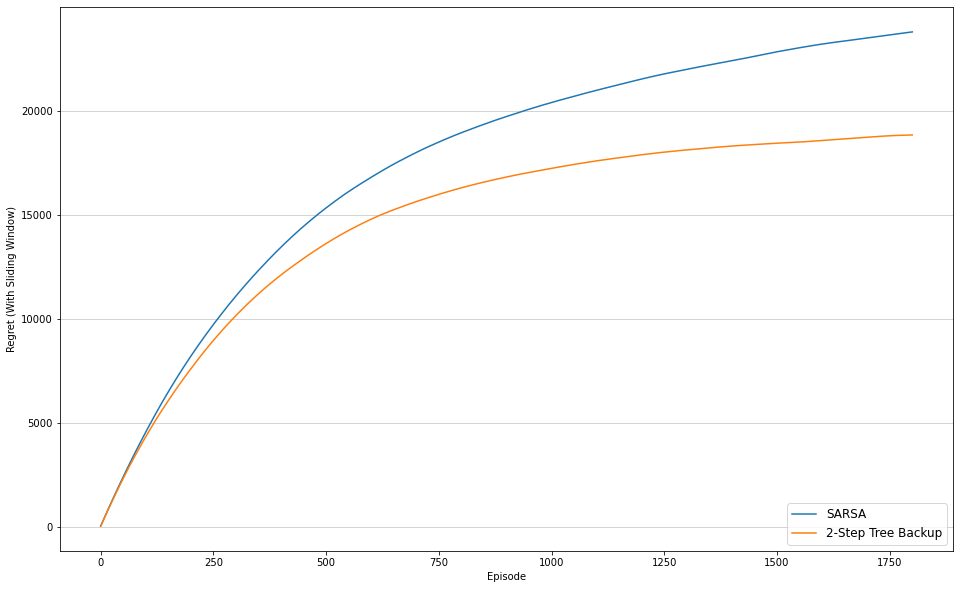

In [212]:
sarsa_regret = regret(optimal_mean_reward, sar_smr)
backup_regret = regret(optimal_mean_reward, backup_smr)
regrets = [sarsa_regret, backup_regret]
labels = ["SARSA", "2-Step Tree Backup"]
plot_regret(regrets, labels)

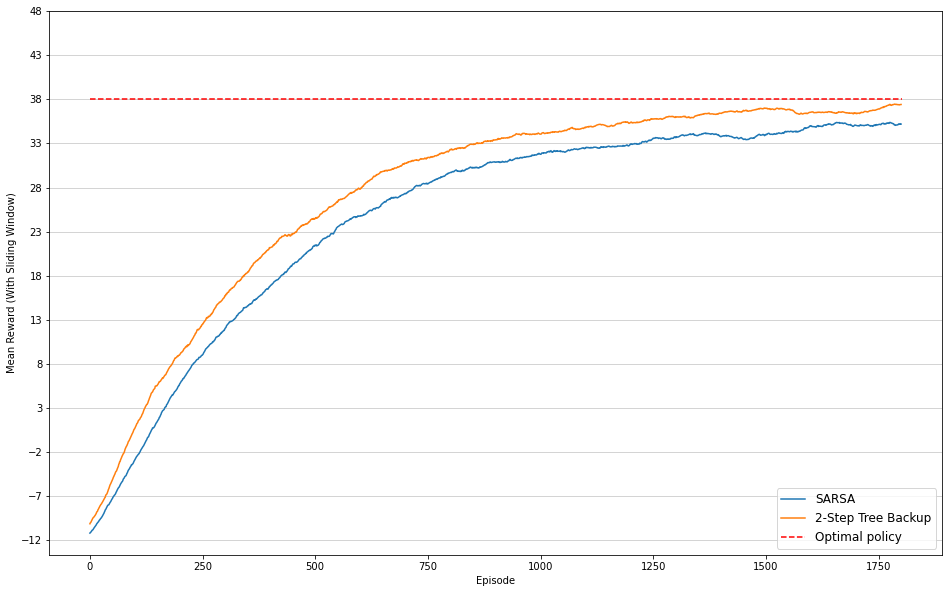

In [213]:
sliding_mean_rewards = [sar_smr, backup_smr]
plot_ar(sliding_mean_rewards, optimal_mean_reward, labels)

# Q3

In [8]:
class MixtureAgent(AgentBase):
    def __init__(self, id, environment, epsilon, w, actions):
        super(MixtureAgent, self).__init__(id, environment)
        self.environment = environment
        self.epsilon = epsilon
        self.w = w
        self.available_actions = actions
        self.q_values = np.zeros((4,4,4))


    def choose_action(self, state) -> (object, float, bool, object):
        
        my_random = np.random.uniform()

        if(my_random < self.epsilon):
            action = np.random.choice(self.available_actions)
        else:
            action = self.choose_best_action(state)
            
        return action
    
    def choose_best_action(self, state):
        action = np.argmax(self.q_values[state[0], state[1], :])
        return action 
    

    def take_action(self, action):
        next_state, r, done,_ = self.environment.step(action)
#         print(current_state, action, next_state, r, done)
        return next_state, r, done, _
    

    
    def update_q(self, s, action, mb_qvalue, mf_qvalue):
        
        # update q
        self.q_values[s[0], s[1], action] = self.w * mb_qvalue + (1-self.w) * mf_qvalue
        
        
    def decay_eps(self, t):
        if t == 0:
            self.initial_epsilon = self.epsilon
        self.epsilon = self.initial_epsilon * np.exp(-t/400)
        return self.epsilon
        
    
    def get_qs(self):
        return self.q_values
        
    def reset(self):
        self.q_values = np.zeros((4,4,4))

In [9]:
def agent_mixture_run(w):
    env = NSFrozenLake(studentNum=STUDENT_NUM, nonStationary=True)
    mean_reward = np.zeros(EPISODES)
    epsilons = np.zeros(EPISODES)

    for rep in range(1, REPS+1): 
        mix_agent = MixtureAgent('6', env, 0.8, w, ACTIONS)
        qlr_agent = QLearningAgent('7', env, 0.1, 0.9, 0.1, ACTIONS)
        qlr_agent.reset()
        mix_agent.reset()
        sum_reward = np.zeros(EPISODES)
        for episode in range(EPISODES):
            env.reset()
            
            eps = mix_agent.decay_eps(episode)


            s = (0,0)
            # generate episode and update q
            while(True):
                # choose A from S using eps-greedy policy
                a = mix_agent.choose_action(s)
                
                # take action A, observe R, S_prime
                s_prime, r, done, _ = mix_agent.take_action(a)
                
                
                # update and get q value of Q-Learning agent
                qlr_agent.update_q(s, s_prime, a, r)
                mf_qvalue = qlr_agent.get_q(s, a)
                
                # get q value of value-iteration
                mb_qvalue = value_iter.get_q(s, a)
                
                # update q value
                mix_agent.update_q(s, a, mb_qvalue, mf_qvalue)
                
                sum_reward[episode] += r

                s = copy.deepcopy(s_prime)
                
                
                if done:
                    break
                    


            # calculate mean reward
            mean_reward[episode] = ((rep - 1)/rep) * mean_reward[episode] + (1/rep) * sum_reward[episode]
    


    return mean_reward, mix_agent.get_qs()

In [254]:
ws = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
EPISODES = 10000
mix_smr_list = []
for i, w in enumerate(ws):
    mix_mr, q = agent_mixture_run(w)
    mix_smr = sliding_mean_reward(mix_mr, 200)
    mix_smr_list.append(mix_smr)

In [258]:
def plot_mean_reward_diff_w(sliding_mean_rewards, labels):
    plt.figure(figsize=(16, 10))
    plt.grid(True, linewidth=0.5, axis='y',color='#AAAAAA', linestyle='-')

    episode_no = np.arange(len(sliding_mean_rewards[0]))

    for i, sliding_mean_reward in enumerate(sliding_mean_rewards):
        plt.plot(episode_no, sliding_mean_reward, label=labels[i])



    plt.xlabel("Episode")
    plt.ylabel("Mean Reward (With Sliding Window)")
    y_min = np.min(sliding_mean_rewards)
    y_max = np.max(sliding_mean_rewards)
    plt.yticks(np.arange(np.ceil(y_min) - 1, np.ceil(y_max) + 5, 5))
    plt.legend(loc='lower right', fontsize='large')
    plt.show();   

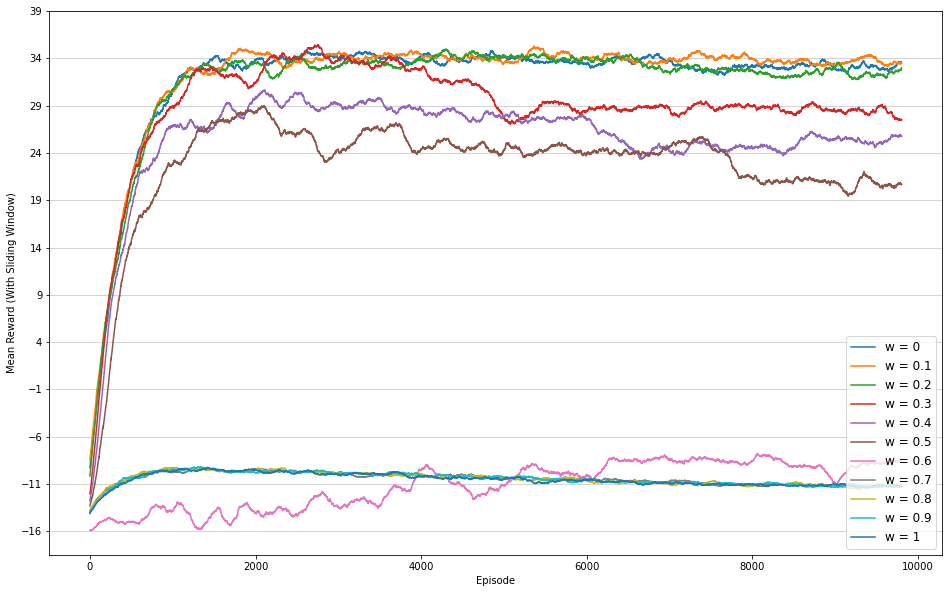

In [259]:
labels = ["w = 0", "w = 0.1", "w = 0.2", "w = 0.3", "w = 0.4", "w = 0.5", "w = 0.6", "w = 0.7", "w = 0.8", "w = 0.9", "w = 1"]
plot_mean_reward_diff_w(mix_smr_list, labels)

# Bonus

In [10]:
class MyAgent(AgentBase):
    def __init__(self, id, environment, epsilon, discount, learning_rate, actions):
        super(MyAgent, self).__init__(id, environment)
        self.environment = environment
        self.epsilon = epsilon
        self.discount = discount
        self.lr = learning_rate
        self.available_actions = actions
        self.state_values = np.zeros((4,4))
        self.q_values = np.zeros((4,4,4))
        self.mean_reward = np.zeros((4,4))
        self.entrance_num = np.zeros((4,4))


    def choose_action(self, current_state) -> (object, float, bool, object):
        
        my_random = np.random.uniform()

        if(my_random < self.epsilon):
            action = np.random.choice(self.available_actions)
        else:
            action = self.choose_best_action(current_state)
            
        return action
    
    def choose_best_action(self, current_state):
        action = np.argmax(self.q_values[current_state[0], current_state[1], :])
        return action 
    

    def take_action(self, action):
        next_state, r, done,_ = self.environment.step(action)
#         print(current_state, action, next_state, r, done)
        return next_state, r, done, _
    

    
    def update_q(self, s, s_prime, action, r):
        
        # update q
        self.q_values[s[0], s[1], action] +=  self.lr * \
                                        ((r + (self.discount * np.max(self.q_values[s_prime[0], s_prime[1], :]))) - \
                                         self.q_values[s[0], s[1], action])
        
    def update_model(self, s_prime, r):
        self.entrance_num[s_prime[0], s_prime[1]] += 1
        n = self.entrance_num[s_prime[0], s_prime[1]]
        self.mean_reward[s_prime[0], s_prime[1]] = ((n-1)/n) * self.mean_reward[s_prime[0], s_prime[1]] + (1/n) * r
        
    def exploit_model(self, state0, state1, action):
        
        # use transition probabilities. we dont use fail_probs because
        # we havent them according to problem assumption.
        states, probs, fail_probs, dones = \
            self.environment.possible_consequences(action=action ,state_now=(state0,state1)) 
        states = np.array(states)

        
        # update q
        r = []
        for state in states:
            r.append(self.mean_reward[state[0],state[1]])

        self.q_values[state0,state1,action] = np.sum(probs * (r + self.discount * self.state_values[states[:,0], states[:,1]]))
        self.state_values[state0, state1] = np.max(self.q_values[state0,state1,:])
        
    def decay_eps(self, t):
        if t == 0:
            self.initial_epsilon = self.epsilon
        self.epsilon = self.initial_epsilon * np.exp(-t/500)
        return self.epsilon
        
        
    def get_qs(self):
        return self.q_values
    
    def get_q(self, s0, s1, action):
        return self.q_values[s0, s1, action]
    
    def get_vs(self):
        return self.state_values
    
    def get_mean_reward(self):
        return self.mean_reward
    
    def get_enter_num(self):
        return self.entrance_num
        
    def reset(self):
        self.state_values = np.zeros((4,4))
        self.q_values = np.zeros((4,4,4))
        self.mean_reward = np.zeros((4,4))
        self.entrance_num = np.zeros((4,4))

In [14]:
def agent_run():
    env = NSFrozenLake(studentNum=STUDENT_NUM)
    mean_reward = np.zeros(EPISODES)
    epsilons = np.zeros(EPISODES)

    for rep in range(1, REPS+1): 
        my_agent = MyAgent('8', env, 0.8, 0.9, 0.1, ACTIONS)
        my_agent.reset()
        sum_reward = np.zeros(EPISODES)
        n = 1
        for episode in range(EPISODES):
            if episode % 500 == 0 and episode != 0:
                n += 2
                if rep == 1:
                    print("Episode: ", episode, ", n = ", n)
            env.reset()
            eps = my_agent.decay_eps(episode)
            if rep == 1:
                epsilons[episode] = eps

            s = (0,0)
            # generate episode and update q
            while(True):
                # choose A from S using eps-greedy policy
                a = my_agent.choose_action(s)

                # take action A, observe R, S_prime
                s_prime, r, done, _ = my_agent.take_action(a)
                sum_reward[episode] += r


                # update q value
                my_agent.update_q(s, s_prime, a, r)
                
                # update model
                my_agent.update_model(s_prime, r)

                s = copy.deepcopy(s_prime)
                
                
                for i in range(n):

                    while(True):
                        state0 = np.random.choice([0, 1, 2, 3])
                        state1 = np.random.choice([0, 1, 2, 3])
                        action = np.random.choice([0, 1, 2, 3])

                        if my_agent.get_q(state0, state1, action) != 0:
                            break

                    my_agent.exploit_model(state0, state1, action)
                
                if done:
                    break
                    

            # calculate mean reward
            mean_reward[episode] = ((rep - 1)/rep) * mean_reward[episode] + (1/rep) * sum_reward[episode]
    

    return mean_reward, my_agent.get_qs(), my_agent.get_vs(), my_agent.get_mean_reward(), my_agent.get_enter_num(), epsilons

Episode:  500 , n =  3
Episode:  1000 , n =  5
Episode:  1500 , n =  7
Episode:  2000 , n =  9
Episode:  2500 , n =  11
Episode:  3000 , n =  13
Episode:  3500 , n =  15


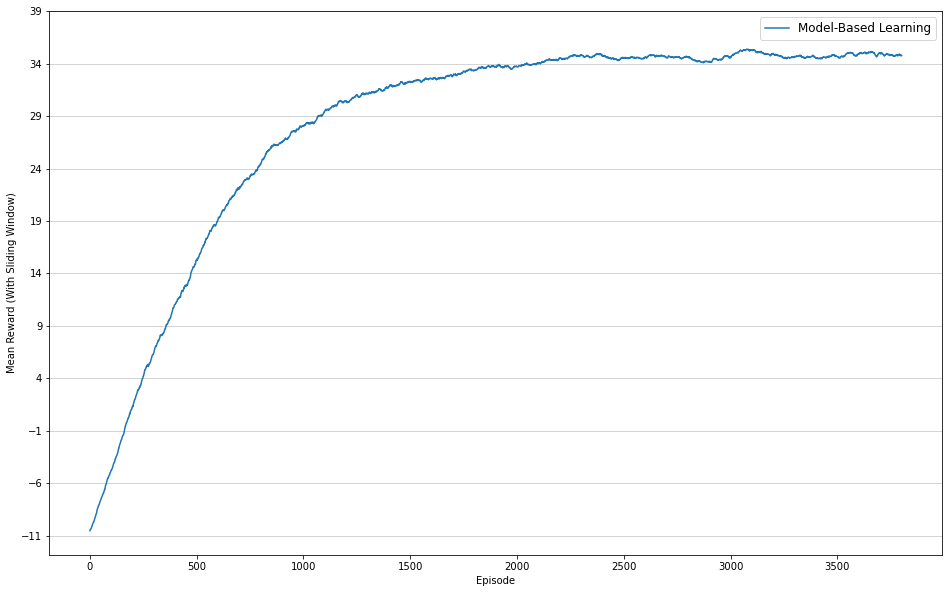

In [15]:
EPISODES = 4000
my_mr, q, v, r, e, eps = agent_run()
my_smr = sliding_mean_reward(my_mr, 200)
plot_sliding_mean_reward(my_smr, "Model-Based Learning")

In [17]:
print(q)

[[[17.88100213  8.01188695 21.18166522 17.88259731]
  [18.31674433 11.0288334  25.35809094 21.5159439 ]
  [22.12621434 30.07714612 22.2849087  25.87702469]
  [25.80631666 25.43471789 22.14114124 22.16795444]]

 [[ 7.73916829 18.29042629 10.48262391 17.5936973 ]
  [ 8.45656595 23.03693831  0.         21.6855369 ]
  [11.16251782 35.15072847 25.4968411  25.90447707]
  [30.28219772 33.70527652 25.84376612 22.56490739]]

 [[18.14163295 18.5775204  22.6541717   8.06266067]
  [19.30939252 29.59540156 34.95578858  0.        ]
  [24.1392791  41.44005291 34.15844474 30.82926899]
  [36.28645092 47.72840624 34.52486351 26.67456645]]

 [[19.05496962 19.02091194 29.38627557  0.        ]
  [19.74158961 30.06905179 40.87385562 23.81823988]
  [31.16545605 41.95273794 48.13754829 36.52592955]
  [ 0.          0.          0.          0.        ]]]


In [18]:
print(r)

[[ -1.          -1.01124101  -1.00935235  -1.27888446]
 [ -8.92307692 -10.50649351  -1.00523697  -4.72759857]
 [ -1.57142857  -8.17647059  -1.01162115  -8.6284585 ]
 [ -7.66666667  -6.54054054  -1.003125    49.        ]]


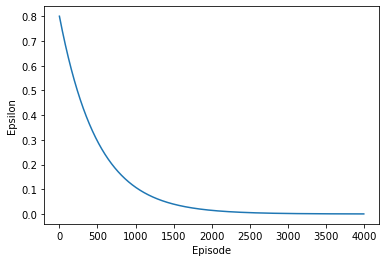

In [16]:
plot_epsilon(eps)